In [69]:
import pandas as pd
import numpy as np
import json
from os.path import exists, join
from matplotlib import pyplot as plt
from scipy.stats.mstats import ttest_ind
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from unicodedata import normalize
import statsmodels.api as sm
import statsmodels as prp
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import os
import csv
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from json.decoder import JSONDecodeError
from scipy.stats import ttest_ind

from unicodedata import normalize
import statsmodels.api as sm
import statsmodels as prp
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [76]:
def calculaTabela(agrupado, banco):  
    desfecho = 'gender'
    prop_genero = calculaProporcaoQualitativo(agrupado, desfecho)
    prop_genero.index = ["F", "M"]
    
    ##'wos_publications','citations','citations_per_item','citations_per_year','h_index'
    
    #var = "hIndex"
    var = "h_index"
    tabela_hindex = calculaProporcao(agrupado, var)
    t_hindex = round(calcTesteHipotese(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    t_hindex_mann = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    t_hindex_levene = round(calcTesteHipoteseLevene(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
     
    #var = "numPublicationsInWos"
    var = "wos_publications"
    tabela_numpublicacoes = calculaProporcao(agrupado, var)
    t_numpublicacoes = round(calcTesteHipotese(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    t_numpublicacoes_mann = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    t_numpublicacoes_levene = round(calcTesteHipoteseLevene(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    
    #var = "timesCited"
    var = "citations"
    tabela_timescited = calculaProporcao(agrupado, var)
    t_timescited = round(calcTesteHipotese(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    t_timescited_mann = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    t_timescited_levene = round(calcTesteHipoteseLevene(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    
    #var = "averagePerItem"
    var = "citations_per_item"
    tabela_averageperitem = calculaProporcao(agrupado, var)
    t_averageperitem = round(calcTesteHipotese(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    t_averageperitem_mann = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    t_averageperitem_levene = round(calcTesteHipoteseLevene(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    
    #var = "averagePerYear"
    var = "citations_per_year"
    tabela_averageperyear = calculaProporcao(agrupado, var)
    t_averageperyear = round(calcTesteHipotese(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    t_averageperyear_mann = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    t_averageperyear_levene = round(calcTesteHipoteseLevene(banco, desfecho, "M", "F", var).pvalue, ndigits=4)
    
    
    cabecalho = pd.Series(["Frequencia",
                 "Índice H", "",
                 "Número de publicações no Web of science", "",
                 "Total de citações", "",
                 "Média de citações por item", "",
                 "Média de citações por ano", ""
                 ])
    
    compilado = pd.concat([
         prop_genero,
         tabela_hindex,
         tabela_numpublicacoes,
         tabela_timescited,
         tabela_averageperitem,
         tabela_averageperyear
               ], axis=1)
    
    compilado.columns = cabecalho
    testes = ["", t_hindex, "", t_numpublicacoes, "", t_timescited, "", t_averageperitem, "", t_averageperyear, ""]
    testes_mann = ["", t_hindex_mann, "", t_numpublicacoes_mann, "", t_timescited_mann, "", t_averageperitem_mann, "", t_averageperyear_mann, ""]
    testes_levene = ["", t_hindex_levene, "", t_numpublicacoes_levene, "", t_timescited_levene, "", t_averageperitem_levene, "", t_averageperyear_levene, ""]
    banco_t = compilado.transpose()
    compilado = pd.concat([banco_t.reset_index(drop=True), 
                           pd.Series(testes).reset_index(drop=True), 
                           pd.Series(testes_mann).reset_index(drop=True), 
                           pd.Series(testes_levene).reset_index(drop=True)], axis=1)
    
    compilado.index = cabecalho
    compilado.columns = ["F", "M", "p-value (t-student)", "p-value (mann)", "p-value (levene)"]
    
    return compilado



def calculaProporcao(agrupado, var): 
    calc_media = round(agrupado[var].mean(), ndigits=2).map(str) + " (" + round(agrupado[var].std(), ndigits=2).map(str) + ")" 
    calc_range = round(agrupado[var].min(), ndigits=2).map(str) + " - " + round(agrupado[var].max(), ndigits=2).map(str)
    calc_proporcao = round(agrupado[var].sum(), ndigits=2).map(str) + \
                           " (" + round(agrupado[var].sum()/sum(agrupado[var].sum()) * 100, ndigits=2).map(str) + " %)"  
    #tabela = pd.concat([calc_media, calc_range, calc_proporcao], axis=1)
    tabela = pd.concat([calc_media, calc_range], axis=1)
    #tabela.columns = ["Média (desvio padrão)", "Min - Máx", "Total (Proporção %)"]   
    tabela.columns = ["Média (desvio padrão)", "Min - Máx"]         

    return tabela #calc_media, calc_range, calc_proporcao


def calcTesteHipotese(banco, col_parametro, param_1, param_2, desfecho):
    banco_1 =  banco[banco[col_parametro] == param_1]  
    banco_2 =  banco[banco[col_parametro] == param_2]  
    calc_ttest = (ttest_ind(banco_1[~np.isnan(banco_1[desfecho])][desfecho], 
                            banco_2[~np.isnan(banco_2[desfecho])][desfecho]))
    return calc_ttest


def calcTesteHipoteseMannWhitney(banco, col_parametro, param_1, param_2, desfecho):
    banco_1 =  banco[banco[col_parametro] == param_1]  
    banco_2 =  banco[banco[col_parametro] == param_2]
    calc_ttest = (mannwhitneyu(banco_1[~np.isnan(banco_1[desfecho])][desfecho], 
                            banco_2[~np.isnan(banco_2[desfecho])][desfecho]))
    return calc_ttest

def calcTesteHipoteseLevene(banco, col_parametro, param_1, param_2, desfecho):
    banco_1 =  banco[banco[col_parametro] == param_1]  
    banco_2 =  banco[banco[col_parametro] == param_2]
    calc_ttest = (levene(banco_1[~np.isnan(banco_1[desfecho])][desfecho], 
                            banco_2[~np.isnan(banco_2[desfecho])][desfecho]))
    return calc_ttest



def calculaProporcaoQualitativo(agrupado, var): 
    calc_proporcao = round(agrupado[var].value_counts(), ndigits=2).map(str) + \
                            " (" + round(agrupado[var].value_counts()/sum(agrupado[var].value_counts()) * 100, ndigits=2).map(str) + " %)"
    tabela = pd.DataFrame(data=pd.Series(list(calc_proporcao)))
    #tabela.columns = ["Gênero"]   
    return tabela


In [75]:
#####Tabela de proporcao e piramide

def calculaProporcao_IC(agrupado, var):
    tabela = pd.DataFrame;
    nova_coluna = []
    for i in range(len(list(agrupado.groups))):    
        coluna = agrupado.get_group(list(agrupado.groups)[i])
        nova_coluna.append(list(agrupado.groups)[i])
        
        calc_proporcao = pd.concat([coluna[var].value_counts()], axis=1, sort=False)
        
        nome_linhas = list(calc_proporcao.index.categories)
        #nome_linhas.append("Total")
        
        #print(calc_proporcao)
        
        calc_proporcao =  pd.DataFrame(calc_proporcao, index=list(nome_linhas))
        if i > 0:
            tabela = pd.concat([tabela, calc_proporcao], axis=1, sort=False)
        else:
            tabela = calc_proporcao
        
        #print(tabela)
    
        tabela.index = nome_linhas
        
    tabela.columns = nova_coluna
    ic = []
    ic_95 = []
    ic_str = []
    for i in range(len(list(tabela.F))):
        if(list(tabela.F)[i] > 0):
            prop = round(list(tabela.M)[i]/list(tabela.F)[i], ndigits=2)
            ic_prop = re_round([x/(1-x) for x in list(
                prp.stats.proportion.proportion_confint(
                    list(tabela.M)[i], list(tabela.M)[i]+list(tabela.F)[i], 
                    alpha=0.05, method='normal'))])
        else:
            prop = " - "
            ic_pro = ["", ""]
            
        ic.append(prop)
        ic_95.append(ic_prop)
        ic_str.append(str(prop).replace(".",",") + " " + 
                      str(ic_prop).replace("[","(").replace("]",")").replace(", ","-").replace(".",","))
        
    intervalos = pd.DataFrame(ic_str, columns =['IC (IC 95%)']) 
    
    intervalos.index = nome_linhas
        
    #print(intervalos)

    return intervalos

def re_round(li, _prec=2):
     try:
         return round(li, _prec)
     except TypeError:
         return type(li)(re_round(x, _prec) for x in li)
     

def myround(x, base=5):
    return base * round(x/base)

def criaPiramideDoIndiceH(prop_genero, xlabel="Número de docentes", titulo="Pirâmide do Índice H por Gênero", 
                          xlim = 500, path="D:\\Google Drive\\Aluna Livia Ciabati\\Pesquisa e gênero\\", 
                          pasta_img="piramide\\", nome_figura="populacao_geral.png"):    
    faixa = list(prop_genero.index.values[:-1])
    
    women_pop = list(prop_genero.F_Num)[:-1]
    men_pop   = list(prop_genero.M_Num)[:-1]
    men_pop = [element * -1 for element in men_pop]
    
    #genero, categoria, total_cat
    col_gen_m = ['M' for element in men_pop]
    col_gen_f = ['F' for element in men_pop]
    
    col_gen = col_gen_m + col_gen_f
    col_cat = faixa + faixa
    col_total_cat = men_pop + women_pop
    
    df = pd.DataFrame({'genero': col_gen, 
                    'categoria': col_cat, 
                    'total_cat': col_total_cat})    
    
    # Draw Plot
    plt.figure(figsize=(16,10), dpi= 200)
    
    group_col = 'genero'
    order_of_bars = df.categoria.unique()[::-1]
    colors = [plt.cm.Spectral(i/float(len(df[group_col].unique())-1)) for i in range(len(df[group_col].unique()))]
        
    for c, group in zip(colors, df[group_col].unique()):
        if(group == "M"):
            label = "Masculino"
        else:
            label = "Feminino"
        sns.barplot(x='total_cat', y='categoria', data=df.loc[df[group_col]==group, :], order=order_of_bars, color=c, label=label)
        
    # Decorations    
    plt.xlabel(xlabel, fontsize=18)
    
    plt.xlim(-xlim, xlim)
    plt.ylabel("Índice H", fontsize=18)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    ##plt.title(titulo, fontsize=22)
    plt.legend()
        
    plt.savefig(path + pasta_img + nome_figura + '.svg', format='svg', dpi=1200)
    plt.savefig(path + pasta_img + nome_figura + '.png', format='png', dpi=1200)    
    plt.savefig(path + pasta_img + nome_figura + '_low.png', format='png', dpi=200)
        
        
    plt.show()

def calculaProporcaoQualitativoMultiCategoria(agrupado, var):     
    tabela = pd.DataFrame;
    nova_coluna = []
    for i in range(len(list(agrupado.groups))):    
        coluna = agrupado.get_group(list(agrupado.groups)[i])
        nova_coluna.append(list(agrupado.groups)[i])
        nova_coluna.append(list(agrupado.groups)[i] + "_Num")
        
        calc_proporcao = pd.concat([round(coluna[var].value_counts(), ndigits=2).map(str) + \
                            " (" + round(coluna[var].value_counts()/sum(coluna[var].value_counts()) * 100, ndigits=2).map(str) + " %)",
                            coluna[var].value_counts()], axis=1, sort=False)
        
        #print(calc_proporcao)
        nome_linhas = list(calc_proporcao.index.categories)
        
        
        calc_proporcao =  pd.DataFrame(calc_proporcao, index=list(nome_linhas))
        nome_linhas.append("Total")
        
        newDF = pd.DataFrame(["",coluna[var].count()]).T
        newDF.columns = [var, var]
        calc_proporcao_total = pd.concat([calc_proporcao, newDF], ignore_index=True)
        
        calc_proporcao_total.index = nome_linhas
        
        #print(calc_proporcao)
        
        if i > 0:
            tabela = pd.concat([tabela, calc_proporcao_total], axis=1, sort=False)
        else:
            tabela = calc_proporcao_total
        #print(tabela)
        tabela.index = nome_linhas
        
    tabela.columns = nova_coluna
    return tabela

In [18]:
#Caminho base
path = "D:\\Google Drive\\Aluna Livia Ciabati\\Pesquisa e gênero\\"

###Le o banco de análise anonimizado
banco_completo_com_depto = pd.read_csv(path + '2020-06-24_publicacao_e_genero\\results\\results_publons_gender_time_anonymized.csv', sep=",", header=0, engine='python', encoding="utf-8")
banco_completo_com_depto.shape
banco_completo_com_depto.head()



,wos_publications,citations,citations_per_item,citations_per_year,h_index,gender,time,usp_unit,usp_dept
0,245,4263,17.40,170.52,31.0,M,21,18,984
1,53,414,7.81,41.40,12.0,M,7,43,1564
2,77,620,8.05,31.00,15.0,M,15,17,2799
3,104,2528,24.31,63.20,26.0,F,44,17,2800
4,60,316,5.27,19.75,9.0,M,32,11,761


In [77]:
## analise da populacao geral
agrupado = banco_completo_com_depto.groupby("gender")
analise_pop_geral = calculaTabela(agrupado, banco_completo_com_depto)
analise_pop_geral

,F,M,p-value (t-student),p-value (mann),p-value (levene)
Frequencia,1176 (38.28 %),1896 (61.72 %),,,
Índice H,12.38 (9.16),14.5 (11.43),0,0,0
,0.0 - 54.0,0.0 - 100.0,,,
Número de publicações no Web of science,49.65 (53.35),66.97 (78.87),0,0,0
,1 - 550,1 - 694,,,
Total de citações,858.56 (1300.35),1346.35 (2654.76),0,0,0
,0 - 13461,0 - 36566,,,
Média de citações por item,14.22 (14.05),16.51 (38.37),0.0494,0.0014,0.2147
,0.0 - 240.3,0.0 - 1536.0,,,
Média de citações por ano,35.86 (46.56),53.9 (109.46),0,0,0


In [54]:
#analise com o ponto de corte do top 100
banco_ordenado = banco_completo_com_depto.sort_values(by="h_index", ascending=False).head(100)
banco_ordenado_ponto_corte = banco_completo_com_depto.sort_values(by="h_index", ascending=False)[banco_completo_com_depto.h_index >= banco_ordenado.h_index.min()]
agrupado_depto = banco_ordenado_ponto_corte.groupby('gender')
analise_100_ponto_corte = calculaTabela(agrupado_depto, banco_ordenado_ponto_corte)
analise_100_ponto_corte

C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,F,M,p-value (t-student),p-value (mann),p-value (levene)
Frequencia,19 (16.96 %),93 (83.04 %),,,
Índice H,42.47 (4.79),45.88 (11.81),0.2199,0.2891,0.1314
,37.0 - 54.0,37.0 - 100.0,,,
Número de publicações no Web of science,228.47 (122.8),265.34 (138.43),0.2839,0.1025,0.4482
,88 - 550,80 - 694,,,
Total de citações,7129.21 (2475.77),9552.09 (6653.04),0.1215,0.0938,0.0891
,4501 - 13461,3966 - 36566,,,
Média de citações por item,35.19 (13.33),39.79 (26.87),0.4694,0.4399,0.2803
,20.09 - 71.35,10.82 - 216.38,,,
Média de citações por ano,230.42 (74.74),335.17 (331.83),0.1752,0.0874,0.1359


In [55]:
### ponto de corte para tempo de servico   
num_anos = 20
result_20_anos = banco_completo_com_depto[banco_completo_com_depto["time"] <= num_anos]
result_20_anos.shape
agrupado = result_20_anos.groupby("gender")
analise_pop_20 = calculaTabela(agrupado, result_20_anos)
analise_pop_20

,F,M,p-value (t-student),p-value (mann),p-value (levene)
Frequencia,823 (39.38 %),1267 (60.62 %),,,
Índice H,10.99 (8.2),13.36 (11.04),0,0,0
,0.0 - 53.0,0.0 - 100.0,,,
Número de publicações no Web of science,41.44 (45.67),57.7 (67.37),0,0,0
,1 - 550,1 - 691,,,
Total de citações,682.08 (1074.07),1178.07 (2588.89),0,0,0
,0 - 11050,0 - 34889,,,
Média de citações por item,13.75 (14.34),15.36 (16.82),0.0232,0.0052,0.2157
,0.0 - 240.3,0.0 - 224.4,,,
Média de citações por ano,32.16 (43.77),52.16 (117.78),0,0,0


In [56]:
banco_ordenado_ponto_corte = result_20_anos.sort_values(by="h_index", ascending=False)[result_20_anos.h_index >= banco_ordenado.h_index.min()]
agrupado_depto = banco_ordenado_ponto_corte.groupby('gender')
analise_20_100_ponto_corte = calculaTabela(agrupado_depto, banco_ordenado_ponto_corte)
analise_20_100_ponto_corte

C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,F,M,p-value (t-student),p-value (mann),p-value (levene)
Frequencia,7 (12.28 %),50 (87.72 %),,,
Índice H,43.43 (4.89),46.94 (14.43),0.5283,0.4035,0.3429
,39.0 - 53.0,37.0 - 100.0,,,
Número de publicações no Web of science,204.0 (155.96),230.66 (105.63),0.5585,0.1167,0.8512
,88 - 550,80 - 525,,,
Total de citações,7160.43 (1912.45),9972.18 (7516.8),0.3323,0.3006,0.2127
,5544 - 11050,3966 - 34889,,,
Média de citações por item,43.28 (16.6),44.78 (31.16),0.9015,0.3531,0.5506
,20.09 - 71.35,18.55 - 216.38,,,
Média de citações por ano,252.59 (56.92),386.16 (405.43),0.3914,0.2147,0.2397


In [57]:
### ponto de corte para tempo de servico   
num_anos = 10
result_10_anos = banco_completo_com_depto[banco_completo_com_depto["time"] <= num_anos]
result_10_anos.shape
agrupado = result_10_anos.groupby("gender")
analise_pop_10 = calculaTabela(agrupado, result_10_anos)
analise_pop_geral

,F,M,p-value (t-student),p-value (mann),p-value (levene)
Frequencia,1176 (38.28 %),1896 (61.72 %),,,
Índice H,12.38 (9.16),14.5 (11.43),0,0,0
,0.0 - 54.0,0.0 - 100.0,,,
Número de publicações no Web of science,49.65 (53.35),66.97 (78.87),0,0,0
,1 - 550,1 - 694,,,
Total de citações,858.56 (1300.35),1346.35 (2654.76),0,0,0
,0 - 13461,0 - 36566,,,
Média de citações por item,14.22 (14.05),16.51 (38.37),0.0494,0.0014,0.2147
,0.0 - 240.3,0.0 - 1536.0,,,
Média de citações por ano,35.86 (46.56),53.9 (109.46),0,0,0


In [58]:
banco_ordenado_ponto_corte = result_10_anos.sort_values(by="h_index", ascending=False)[result_10_anos.h_index >= banco_ordenado.h_index.min()]
agrupado_depto = banco_ordenado_ponto_corte.groupby('gender')
#analise_10_100_ponto_corte = calculaTabela(agrupado_depto, banco_ordenado_ponto_corte)
#analise_10_100_ponto_corte

C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [59]:

writer = pd.ExcelWriter(path + "analise_professores_"+str(num_anos)+"_anos_fisher.xlsx", engine = 'xlsxwriter')
analise_pop_geral.to_excel(writer, sheet_name = 'analise_pop_geral')
analise_100_ponto_corte.to_excel(writer, sheet_name = 'analise_100_ponto_corte')

analise_pop_20.to_excel(writer, sheet_name = 'analise_20')
analise_20_100_ponto_corte.to_excel(writer, sheet_name = 'analise_20_100_ponto_corte')

analise_pop_10.to_excel(writer, sheet_name = 'analise_10')
#analise_10_100_ponto_corte.to_excel(writer, sheet_name = 'analise_10_100_ponto_corte')

writer.save()
writer.close()


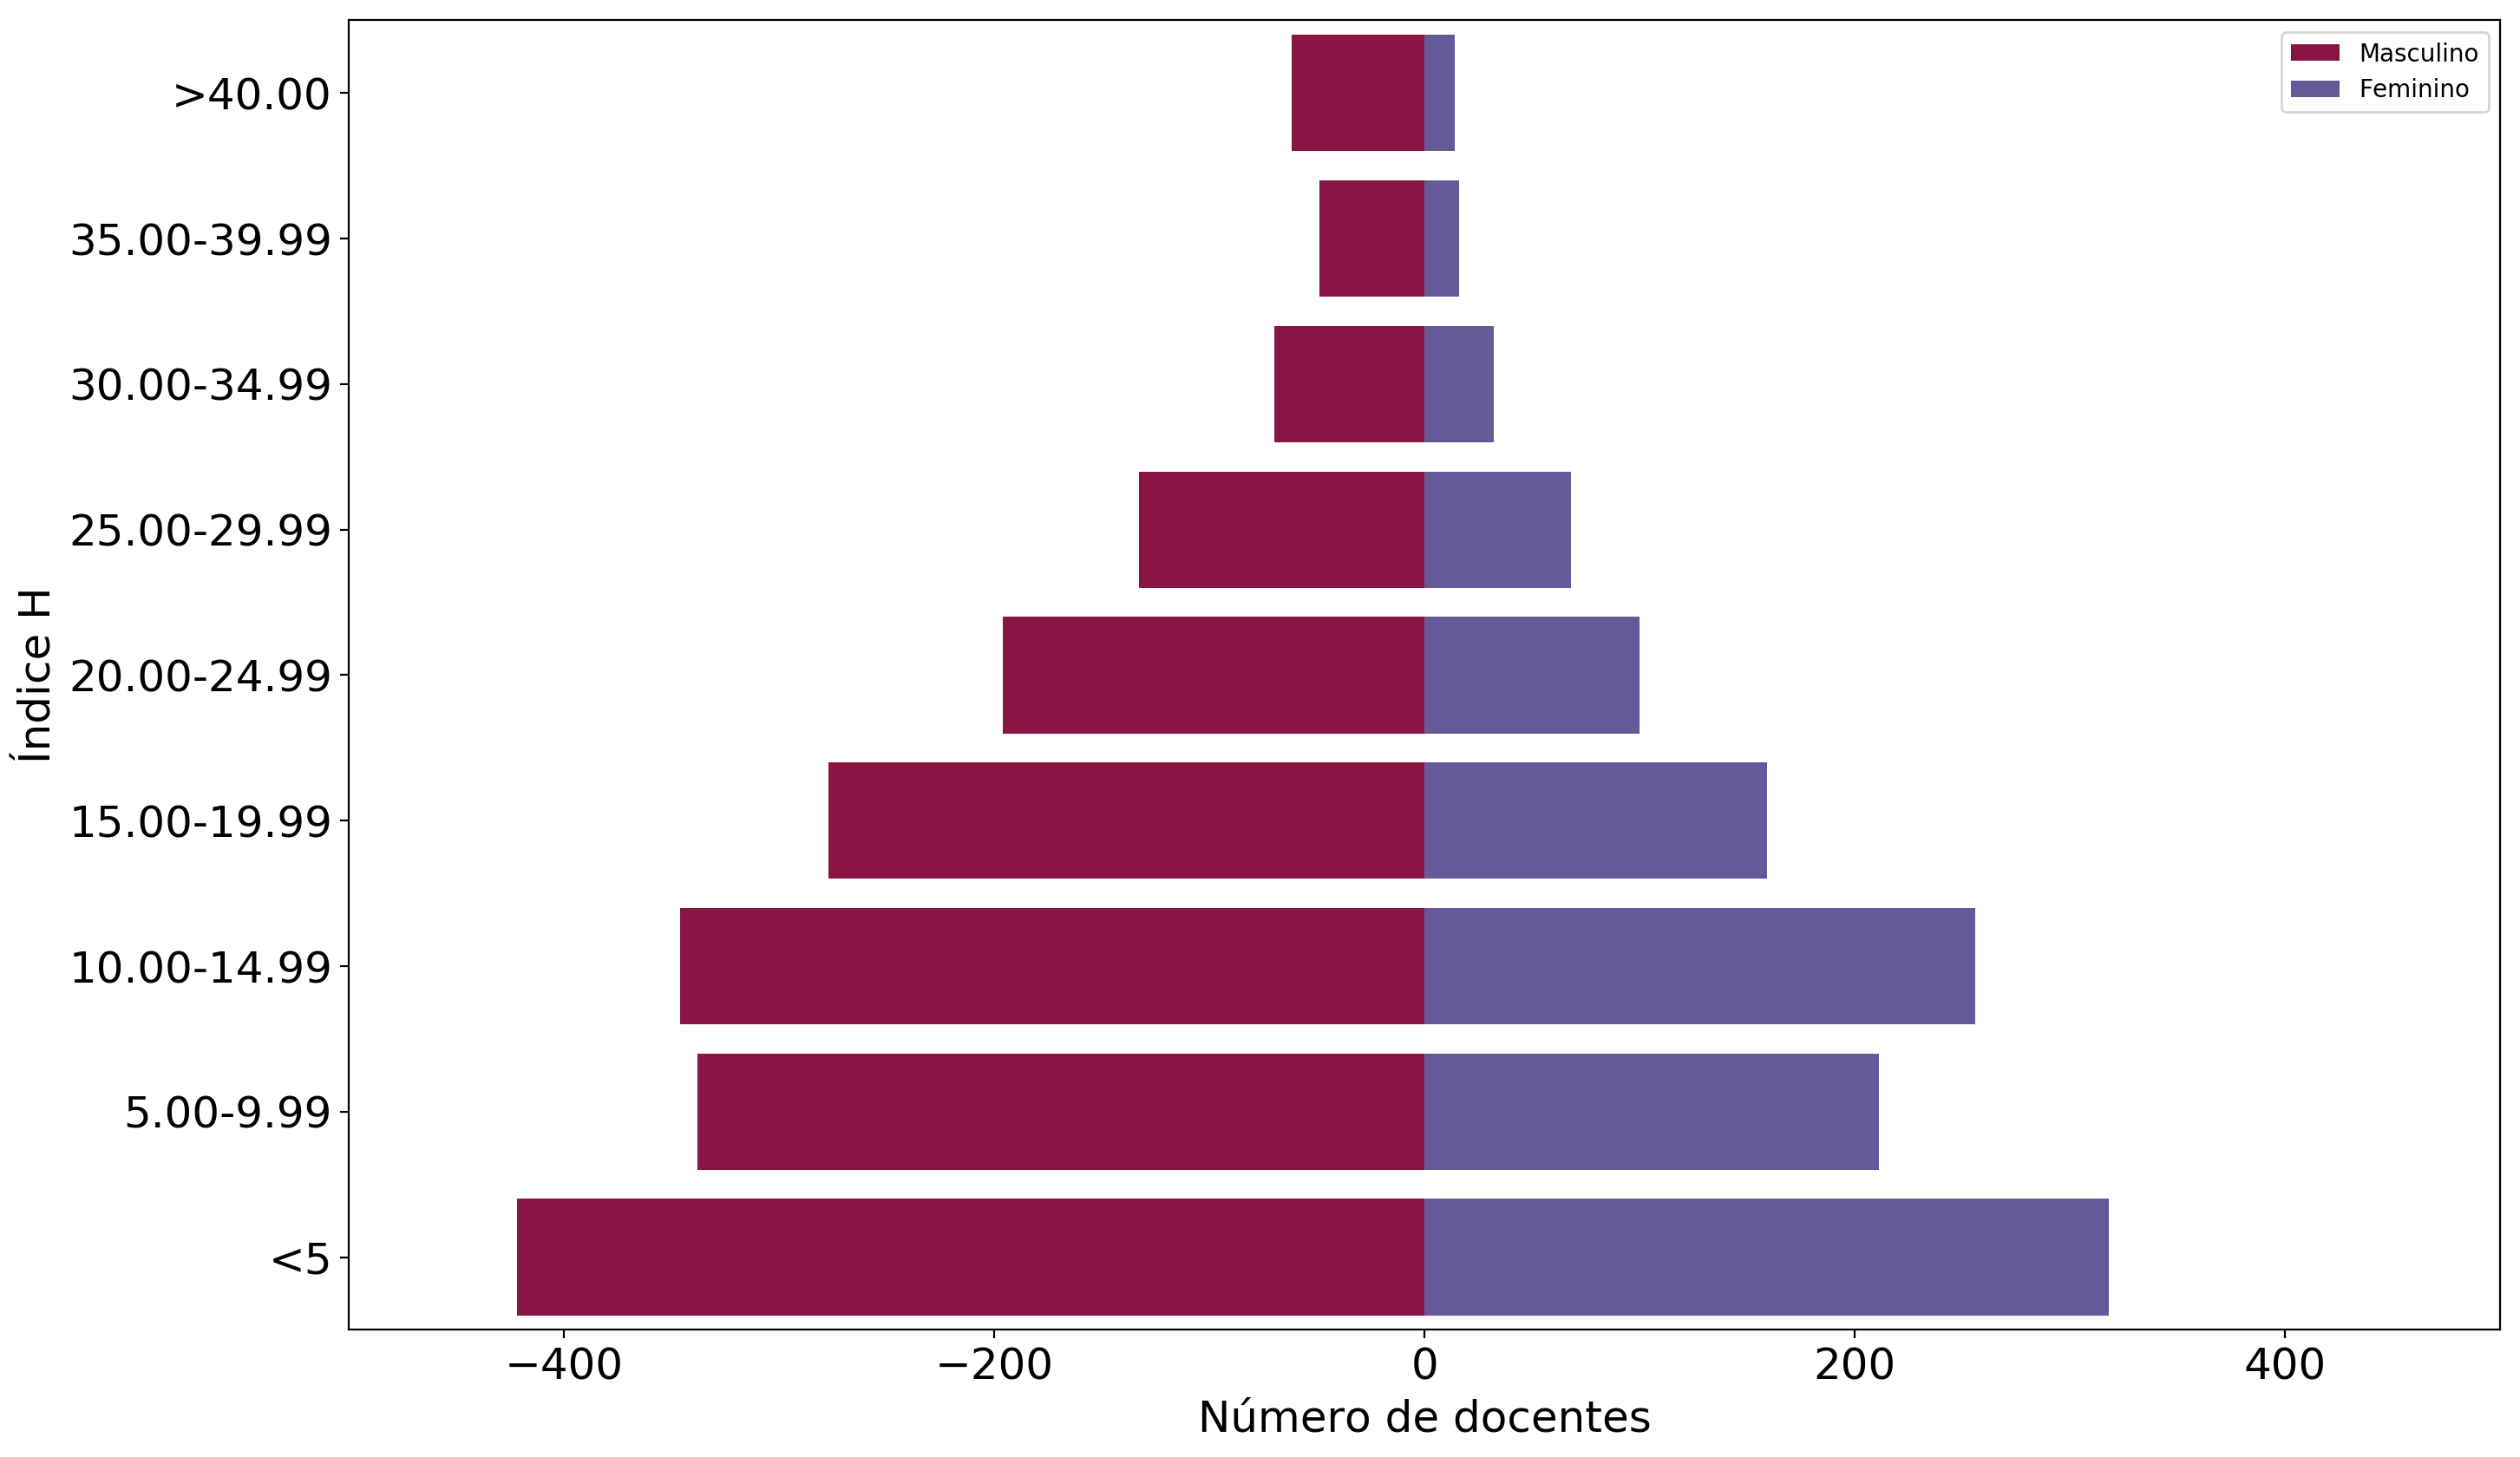

In [72]:

##Análise com intervalo de 5
faixa_bins = [0,5,9.99,14.99,19.99,24.99,29.99,34.99,39.99,500]
faixa_label = ['<5','5.00-9.99','10.00-14.99','15.00-19.99','20.00-24.99','25.00-29.99','30.00-34.99','35.00-39.99','>40.00']

########### Análise para a população geral
##Recategoriza o indice H em faixas
h_index_categorico = pd.cut(banco_completo_com_depto.h_index, bins=faixa_bins, include_lowest=True, labels=faixa_label)
banco_h_categorico = pd.concat([banco_completo_com_depto, h_index_categorico.rename("hIndexCat")], axis=1)
agrupado = banco_h_categorico.groupby("gender")

prop_genero = calculaProporcaoQualitativoMultiCategoria(agrupado, "hIndexCat")
intervalosPRO = calculaProporcao_IC(agrupado, "hIndexCat")

criaPiramideDoIndiceH(prop_genero);


In [82]:
########### Análise para a população com <= 20 anos de serviço
num_anos = 20
result_20_anos = banco_completo_com_depto[banco_completo_com_depto["time"] <= num_anos]
result_20_anos.shape

h_index_categorico = pd.cut(result_20_anos.h_index, bins=faixa_bins, include_lowest=True, labels=faixa_label)
banco_h_categorico = pd.concat([result_20_anos, h_index_categorico.rename("hIndexCat")], axis=1)
agrupado_20 = banco_h_categorico.groupby("gender")

prop_genero_20 = calculaProporcaoQualitativoMultiCategoria(agrupado_20, "hIndexCat")
intervalosPRO_20 = calculaProporcao_IC(agrupado_20, "hIndexCat")
print(prop_genero_20)
print(intervalosPRO_20)

                         F F_Num              M M_Num
<5           252 (30.69 %)   252  320 (25.28 %)   320
5.00-9.99    157 (19.12 %)   157  231 (18.25 %)   231
10.00-14.99  193 (23.51 %)   193  245 (19.35 %)   245
15.00-19.99  105 (12.79 %)   105  190 (15.01 %)   190
20.00-24.99    57 (6.94 %)    57    114 (9.0 %)   114
25.00-29.99    33 (4.02 %)    33    73 (5.77 %)    73
30.00-34.99    10 (1.22 %)    10    31 (2.45 %)    31
35.00-39.99      9 (1.1 %)     9    29 (2.29 %)    29
>40.00          5 (0.61 %)     5    33 (2.61 %)    33
Total                        821                 1266
                  IC (IC 95%)
<5            1,27 (1,08-1,5)
5.00-9.99    1,47 (1,21-1,81)
10.00-14.99  1,27 (1,05-1,54)
15.00-19.99  1,81 (1,44-2,32)
20.00-24.99   2,0 (1,48-2,81)
25.00-29.99   2,21 (1,5-3,48)
30.00-34.99   3,1 (1,66-7,89)
35.00-39.99  3,22 (1,69-8,84)
>40.00       6,6 (3,18-40,49)


In [ ]:
criaPiramideDoIndiceH(prop_genero_20, titulo= "Pirâmide do Índice H por Gênero\n(População com <=20 anos de serviço a Universidade de São Paulo)"
                      , nome_figura="lt_20_anos.png");


In [86]:
########### Análise para a população com <= 10 anos de serviço
num_anos = 10
result = banco_completo_com_depto[banco_completo_com_depto["time"] <= num_anos]
result_10_anos.shape

h_index_categorico = pd.cut(result_10_anos.h_index, bins=faixa_bins, include_lowest=True, labels=faixa_label)
banco_h_categorico = pd.concat([result_10_anos, h_index_categorico.rename("hIndexCat")], axis=1)
agrupado_10 = banco_h_categorico.groupby("gender")

prop_genero_10 = calculaProporcaoQualitativoMultiCategoria(agrupado_10, "hIndexCat")
intervalosPRO_10 = calculaProporcao_IC(agrupado_10, "hIndexCat")
print(prop_genero_10)
print(intervalosPRO_10)


                         F F_Num              M M_Num
<5           140 (31.96 %)   140  180 (25.03 %)   180
5.00-9.99     81 (18.49 %)    81  134 (18.64 %)   134
10.00-14.99  111 (25.34 %)   111   151 (21.0 %)   151
15.00-19.99   51 (11.64 %)    51  103 (14.33 %)   103
20.00-24.99    31 (7.08 %)    31    56 (7.79 %)    56
25.00-29.99     14 (3.2 %)    14    36 (5.01 %)    36
30.00-34.99     6 (1.37 %)     6    20 (2.78 %)    20
35.00-39.99     4 (0.91 %)     4    15 (2.09 %)    15
>40.00           0 (0.0 %)     0    24 (3.34 %)    24
Total                        438                  719
                   IC (IC 95%)
<5            1,29 (1,03-1,61)
5.00-9.99     1,65 (1,26-2,21)
10.00-14.99   1,36 (1,07-1,75)
15.00-19.99   2,02 (1,47-2,89)
20.00-24.99   1,81 (1,19-2,91)
25.00-29.99   2,57 (1,47-5,43)
30.00-34.99  3,33 (1,55-13,53)
35.00-39.99  3,75 (1,54-35,75)
>40.00         -  (1,54-35,75)


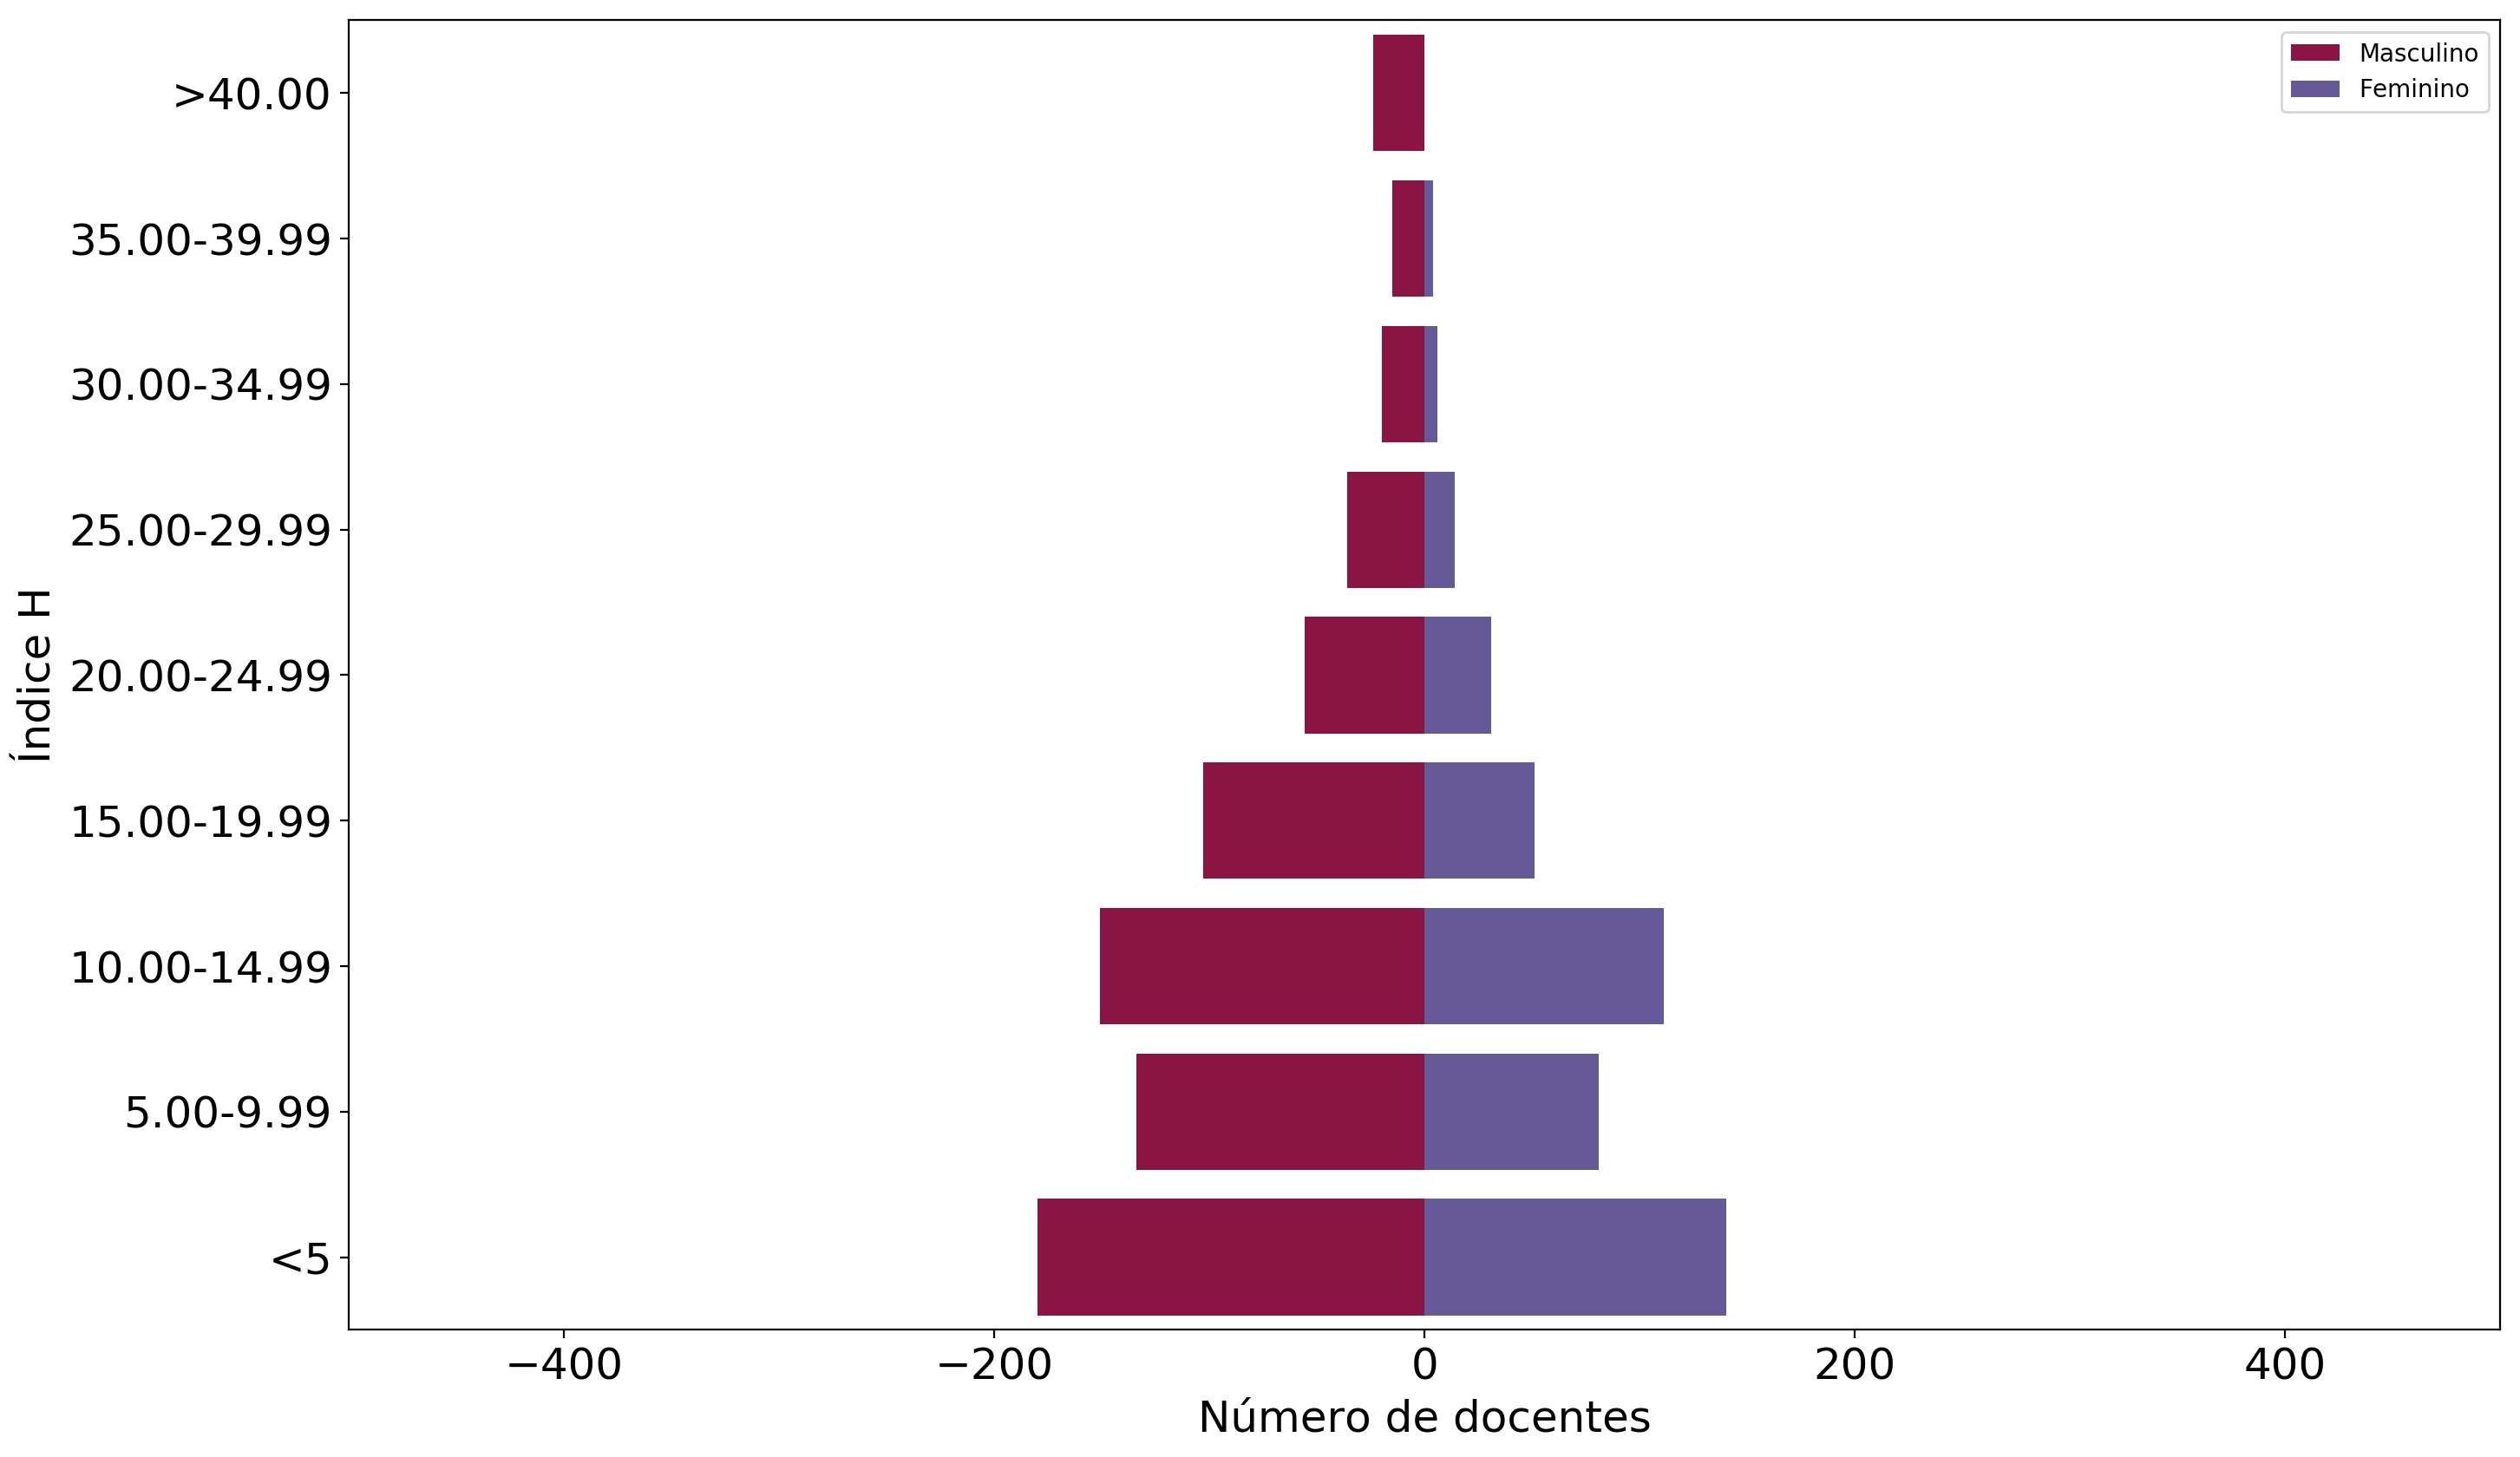

In [83]:
criaPiramideDoIndiceH(prop_genero_10, titulo= "Pirâmide do Índice H por Gênero\n(População com <=10 anos de serviço a Universidade de São Paulo)"
                      , nome_figura="lt_10_anos.png");